# Socialinių medijų analitikos egzamino projektas (VDU, 2025)

Šiame socialinių medijų analitikos projekte atliekama išsami dirbtinio intelekto tyrimo sričių ir tyrėjų analizė. Tyrimas remiasi duomenimis, surinktais iš “Web of Science” duomenų bazės,
fokusuojantis į labiausiai cituojamas mokslines publikacijas šia tematika. Projekto įgyvendinimui taikomas hibridinis analitikos būdas, apjungiantis dvi pagrindines metodologijas:

1. **Natūralios kalbos apdorojimą (angl. NLP - Natural Language Processing)**:
Naudojant didžiuosius kalbos modelius, semantinius vektorius / įterpinius (Embeddings),
bei klasterizavimo algoritmus (HDBSCAN), siekiama automatiškai identifikuoti ir
sugrupuoti publikacijas į specifines tyrimo sritis.
2. **Tinklų analizę**: Konstruojami bendraautorystės tinklai, kuriuose viršūnės reprezentuoja
autorius, o briaunos – bendrą darbą. Tai leidžia vizualizuoti ir matematiškai įvertinti
tyrėjų bei jų grupių įtaką tiek atskirose srityse, tiek visame giliojo mokymosi lauke.

Šio tyrimo eigoje siekiama atsakyti į tris esminius probleminius klausimus:
1. Kokios yra **įtakingiausios tyrimo sritys** giliojo mokymosi tematikoje?
2. Kas yra **įtakingiausi tyrėjai ir tyrėjų grupės** konkrečiai išskirtose **populiariausiose tyrimo
srityse**?
3. Kas yra **įtakingiausi tyrėjai ir tyrėjų grupės vertinant visą giliojo mokymosi lauką
bendrai**?

# Duomenų paruošimas

Nuskaitome pagrindinį duomenų šaltinį `./dataset/papers.csv`.

Šiame duomenų šaltinyje yra surinkti 10000 labiausiai cituojamų publikacijų iš dirbtinio intelekto lauko.

Projekte naudosime tik šiuos duomenis:
1. `Article Title` - publikacijos pavadinimas.
2. `Abstract` - publikacijos santrauka.
3. `Authors` - autoriai.
4. `Times Cited` - citatų kiekis.

In [1]:
import pandas as pd

df = pd.read_csv('./dataset/papers.csv', low_memory=False)
df = df.rename(columns={'Times Cited, All Databases': 'Times Cited'})
df = df[['Article Title', 'Abstract', 'Authors', 'Times Cited']]
df

,Article Title,Abstract,Authors,Times Cited
0,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...,"He, KM; Zhang, XY; Ren, SQ; Sun, J",142551
1,Attention Is All You Need,The dominant sequence transduction models are ...,"Vaswani, A; Shazeer, N; Parmar, N; Uszkoreit, ...",91998
2,Random forests,Random forests are a combination of tree predi...,"Breiman, L",88025
3,U-Net: Convolutional Networks for Biomedical I...,There is large consent that successful trainin...,"Ronneberger, O; Fischer, P; Brox, T",79839
4,Scikit-learn: Machine Learning in Python,Scikit-learn is a Python module integrating a ...,"Pedregosa, F; Varoquaux, G; Gramfort, A; Miche...",71938
...,...,...,...,...
9995,Learning Generative Models with Sinkhorn Diver...,The ability to compare two degenerate probabil...,"Genevay, A; Peyré, G; Cuturi, M",292
9996,Cooperative Learning of Audio and Video Models...,There is a natural correlation between the vis...,"Korbar, B; Tran, D; Torresani, L",302
9997,Learning for Disparity Estimation through Feat...,Stereo matching algorithms usually consist of ...,"Liang, ZF; Feng, YL; Guo, YL; Liu, HZ; Chen, W...",327
9998,Fast and Effective Robustness Certification,"We present a new method and system, called Dee...","Singh, G; Gehr, T; Mirman, M; Püschel, M; Vech...",316


Pašaliname įrašus, turinčius pasikartojančias *Article Title* ir *Abstract* bei neegzistuojančias reikšmes bent viename iš stulpelių.

In [2]:
df = df.drop_duplicates(subset=['Article Title'])
df = df.drop_duplicates(subset=['Abstract'])
df = df.dropna(subset=['Article Title', 'Abstract', 'Authors', 'Times Cited'])
df.reset_index()

,index,Article Title,Abstract,Authors,Times Cited
0,0,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...,"He, KM; Zhang, XY; Ren, SQ; Sun, J",142551
1,1,Attention Is All You Need,The dominant sequence transduction models are ...,"Vaswani, A; Shazeer, N; Parmar, N; Uszkoreit, ...",91998
2,2,Random forests,Random forests are a combination of tree predi...,"Breiman, L",88025
3,3,U-Net: Convolutional Networks for Biomedical I...,There is large consent that successful trainin...,"Ronneberger, O; Fischer, P; Brox, T",79839
4,4,Scikit-learn: Machine Learning in Python,Scikit-learn is a Python module integrating a ...,"Pedregosa, F; Varoquaux, G; Gramfort, A; Miche...",71938
...,...,...,...,...,...
9716,9995,Learning Generative Models with Sinkhorn Diver...,The ability to compare two degenerate probabil...,"Genevay, A; Peyré, G; Cuturi, M",292
9717,9996,Cooperative Learning of Audio and Video Models...,There is a natural correlation between the vis...,"Korbar, B; Tran, D; Torresani, L",302
9718,9997,Learning for Disparity Estimation through Feat...,Stereo matching algorithms usually consist of ...,"Liang, ZF; Feng, YL; Guo, YL; Liu, HZ; Chen, W...",327
9719,9998,Fast and Effective Robustness Certification,"We present a new method and system, called Dee...","Singh, G; Gehr, T; Mirman, M; Püschel, M; Vech...",316


Sukuriame funkciją, kuri užtikrins, kad tekstas, pavertus jį į žetonus (angl. tokens) nebus ilgesnis nei 512. To reikia, norint išvengti klaidų dėl per ilgo konteksto dydžio.

In [33]:
from tqdm.notebook import tqdm as notebook_tqdm
from transformers import AutoTokenizer
import transformers

transformers.logging.set_verbosity_error()

encoding = AutoTokenizer.from_pretrained("bert-base-uncased")

def safe_truncate(title, text, max_tokens=510):
    tokens = encoding.encode(text)
    if len(tokens) > max_tokens:
        print(f"⚠️ Text for `{title}` too long ({len(tokens)} tokens). Truncating to {max_tokens}.")
        tokens = tokens[:max_tokens]
        return encoding.decode(tokens)
    return text

In [4]:
df['Abstract'] = [safe_truncate(row['Article Title'], row['Abstract']) for idx, row in df.iterrows()]
df

⚠️ Text for `Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization` too long (552 tokens). Truncating to 510.
⚠️ Text for `Literature review of Industry 4.0 and related technologies` too long (854 tokens). Truncating to 510.
⚠️ Text for `Hunger games search: Visions, conception, implementation, deep analysis, perspectives, and towards performance shifts` too long (668 tokens). Truncating to 510.
⚠️ Text for `RESTRUCTURING LATTICE THEORY: AN APPROACH BASED ON HIERARCHIES OF CONCEPTS` too long (902 tokens). Truncating to 510.
⚠️ Text for `A Novel Multiresolution Spatiotemporal Saliency Detection Model and Its Applications in Image and Video Compression` too long (531 tokens). Truncating to 510.
⚠️ Text for `CONSTRAINED RESTORATION AND THE RECOVERY OF DISCONTINUITIES` too long (513 tokens). Truncating to 510.
⚠️ Text for `ESTIMATION OF PLANAR CURVES, SURFACES, AND NONPLANAR SPACE-CURVES DEFINED BY IMPLICIT EQUATIONS WITH APPLICATIONS TO EDGE AND RANGE IMAGE SEGM

,Article Title,Abstract,Authors,Times Cited
0,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...,"He, KM; Zhang, XY; Ren, SQ; Sun, J",142551
1,Attention Is All You Need,The dominant sequence transduction models are ...,"Vaswani, A; Shazeer, N; Parmar, N; Uszkoreit, ...",91998
2,Random forests,Random forests are a combination of tree predi...,"Breiman, L",88025
3,U-Net: Convolutional Networks for Biomedical I...,There is large consent that successful trainin...,"Ronneberger, O; Fischer, P; Brox, T",79839
4,Scikit-learn: Machine Learning in Python,Scikit-learn is a Python module integrating a ...,"Pedregosa, F; Varoquaux, G; Gramfort, A; Miche...",71938
...,...,...,...,...
9995,Learning Generative Models with Sinkhorn Diver...,The ability to compare two degenerate probabil...,"Genevay, A; Peyré, G; Cuturi, M",292
9996,Cooperative Learning of Audio and Video Models...,There is a natural correlation between the vis...,"Korbar, B; Tran, D; Torresani, L",302
9997,Learning for Disparity Estimation through Feat...,Stereo matching algorithms usually consist of ...,"Liang, ZF; Feng, YL; Guo, YL; Liu, HZ; Chen, W...",327
9998,Fast and Effective Robustness Certification,"We present a new method and system, called Dee...","Singh, G; Gehr, T; Mirman, M; Püschel, M; Vech...",316


Generuojame įterpinius (angl. embeddings).


In [5]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [6]:
import ollama

batch_size = 10
embeddings = []
texts = df['Abstract'].tolist()

for i in notebook_tqdm(range(0, len(texts), batch_size)):
    batch = texts[i: i + batch_size]
    embeddings.extend(ollama.embed(model='nomic-embed-text:latest', input=batch)['embeddings'])

df['Embedding'] = embeddings
df[['Article Title', 'Times Cited', 'Embedding']]

  0%|          | 0/973 [00:00<?, ?it/s]

,Article Title,Times Cited,Embedding
0,Deep Residual Learning for Image Recognition,142551,"[0.020417841, 0.056589052, -0.16318522, -0.071..."
1,Attention Is All You Need,91998,"[-0.032924563, 0.046121493, -0.19367628, -0.03..."
2,Random forests,88025,"[-0.0072813923, 0.024357364, -0.19535853, -0.0..."
3,U-Net: Convolutional Networks for Biomedical I...,79839,"[0.021520033, 0.10052541, -0.16772927, -0.0200..."
4,Scikit-learn: Machine Learning in Python,71938,"[-0.019265702, 0.036767792, -0.14098856, -0.05..."
...,...,...,...
9995,Learning Generative Models with Sinkhorn Diver...,292,"[0.006038927, 0.05801409, -0.17992993, -0.0392..."
9996,Cooperative Learning of Audio and Video Models...,302,"[0.029889455, -0.0041276915, -0.19609454, 0.00..."
9997,Learning for Disparity Estimation through Feat...,327,"[0.005575923, 0.058550518, -0.17064108, -0.031..."
9998,Fast and Effective Robustness Certification,316,"[0.06958257, 0.03470636, -0.17780356, -0.03145..."


Klasterizuojame straipsnius remiantis jų įterpiniais.

Pirmiausia, sumažiname vektorių dimensijas iki dviejų, naudojantis UMAP ir PCA metodais.

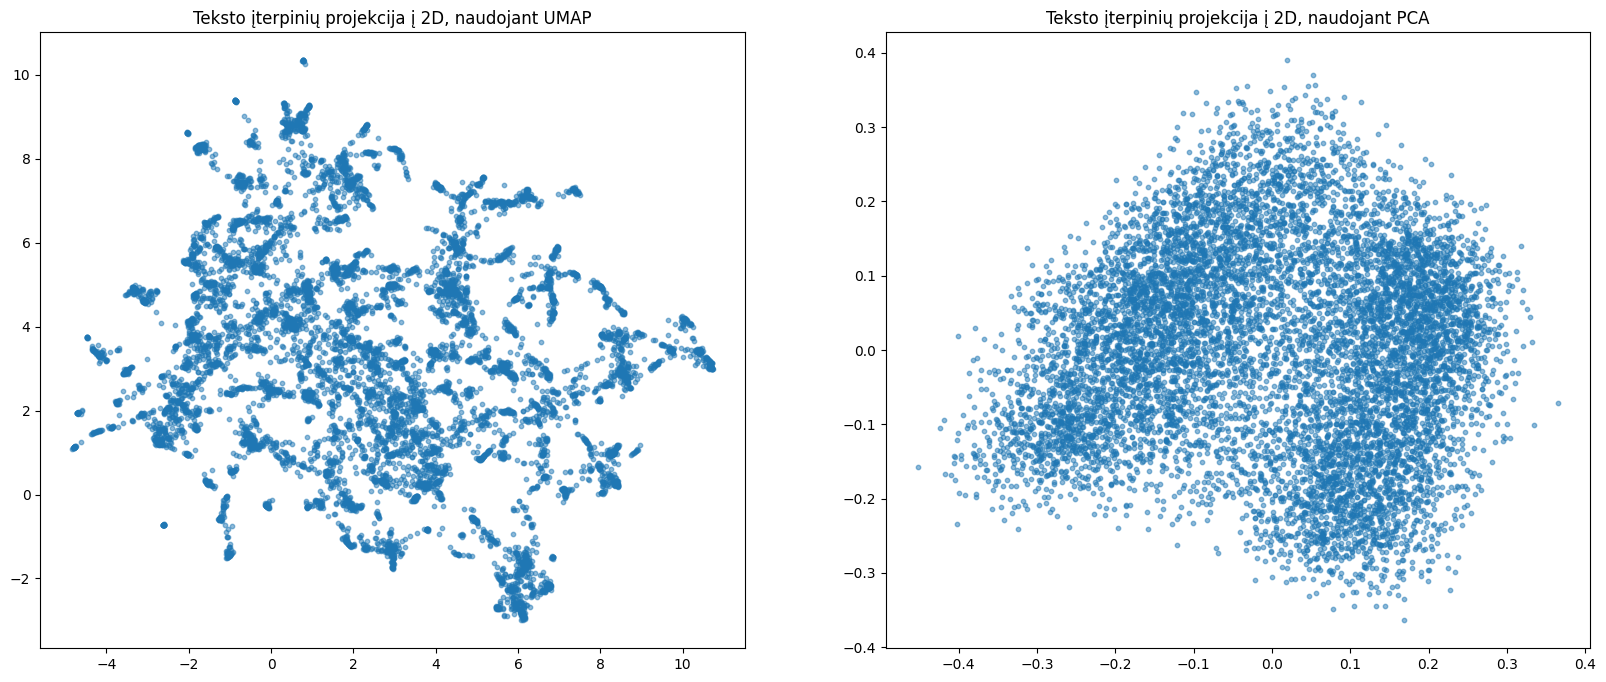

In [7]:
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.decomposition import PCA
import numpy as np

X = df['Embedding']
X_mat = np.vstack(X.values).astype(np.float32)

# UMAP
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42, n_jobs=1)
X_projected_umap = umap.fit_transform(X_mat).astype(np.float64)

# PCA
pca = PCA(n_components=2)
X_projected_pca = pca.fit_transform(X_mat).astype(np.float64)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.scatter(X_projected_umap[:, 0], X_projected_umap[:, 1], s=10, alpha=0.5)
ax1.set_title('Teksto įterpinių projekcija į 2D, naudojant UMAP')
ax2.scatter(X_projected_pca[:, 0], X_projected_pca[:, 1], s=10, alpha=0.5)
ax2.set_title('Teksto įterpinių projekcija į 2D, naudojant PCA')

plt.show()

Matome, kad UMAP diagramoje galima geriau įžvelgti klasterius. Toliau naudosime UMAP.

In [9]:
from hdbscan import HDBSCAN

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=20, metric='cosine', random_state=42, n_jobs=1)
X_projected = umap.fit_transform(X_mat)
X_projected = X_projected.astype(np.float64)

clusterer = HDBSCAN(
    min_cluster_size=10,
    min_samples=10,                    
    metric='cosine',
    algorithm='generic',               
    cluster_selection_epsilon=0.0001,
    cluster_selection_method='eom'
)
labels = clusterer.fit_predict(X_projected)

df = df.copy()
df['Cluster'] = labels
df = df[df['Cluster'] != -1] # pašaliname įrašus, nepriskirtus jokiam klasteriui
df[['Article Title', 'Times Cited', 'Cluster']]

,Article Title,Times Cited,Cluster
0,Deep Residual Learning for Image Recognition,142551,52
1,Attention Is All You Need,91998,49
2,Random forests,88025,52
6,Long short-term memory,65190,49
7,Faster R-CNN: Towards Real-Time Object Detecti...,56807,52
...,...,...,...
9995,Learning Generative Models with Sinkhorn Diver...,292,52
9996,Cooperative Learning of Audio and Video Models...,302,35
9997,Learning for Disparity Estimation through Feat...,327,48
9998,Fast and Effective Robustness Certification,316,52


2D diagrama, naudojant spalvinimą, leidžiantį pamatyti klasterius.

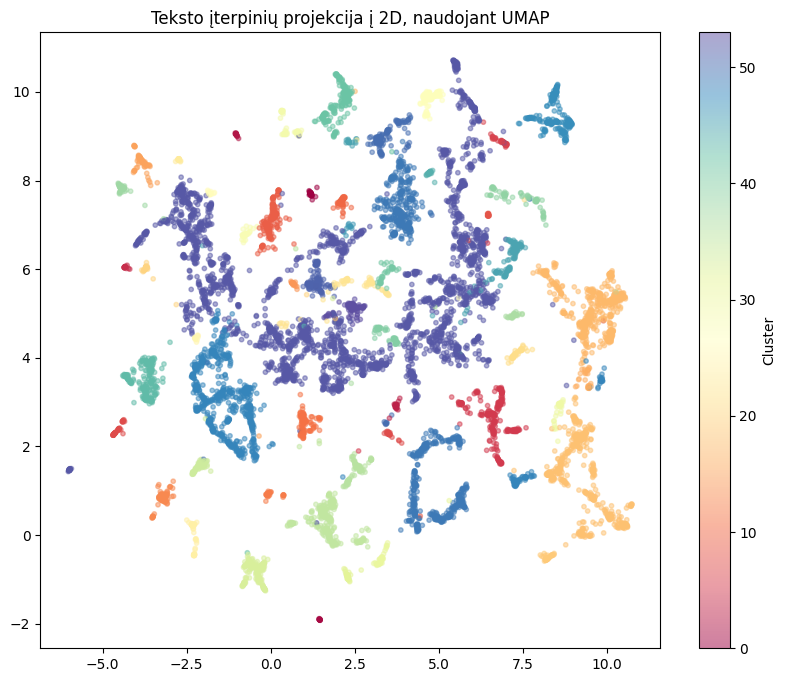

In [10]:
X = df['Embedding']
X_mat = np.vstack(X.values).astype(np.float32)

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42, n_jobs=1)
X_projected = umap.fit_transform(X_mat)
X_projected = X_projected.astype(np.float64)

plt.figure(figsize=(10, 8))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=df['Cluster'], cmap='Spectral', s=10, alpha=0.5)
plt.title('Teksto įterpinių projekcija į 2D, naudojant UMAP')
plt.colorbar(label='Cluster')
plt.show()

Generuojame straipsnių temas, pasitelkiant Ollama `gpt-oss:20b` modelį.

In [11]:
def define_topic(texts):
    summary_prompt = "Create a single label that best describe these scientific papers' abstracts taken from an artificial intelligence field. Output only the label and do not mention artificial intelligence as it is implied already:\n\n" + "------------------\n".join(texts)
    r = ollama.chat(model='gpt-oss:20b', messages=[{"role": "user", "content": summary_prompt}])
    return r['message']['content'].strip()

sampled = df.groupby("Cluster", group_keys=False).apply(lambda x: x.sort_values("Times Cited", ascending=False).head(5))

cluster_labels = []
for cluster_id, group_df in sampled.groupby("Cluster"):
    topic_label = define_topic(group_df['Abstract'].tolist())
    print(f"Cluster {cluster_id}: {topic_label}")
    cluster_labels.append((cluster_id, topic_label))

cluster_labels_cleaned = [(cid, label.strip()) for cid, label in cluster_labels]
cluster_to_label = dict(cluster_labels_cleaned)

df['Topic'] = df['Cluster'].map(cluster_to_label)
df[['Article Title', 'Times Cited', 'Cluster', 'Topic']]

Cluster 0: Binary hashing for efficient similarity search
Cluster 1: Human Gait Recognition
Cluster 2: Facial Age Estimation & Aging Simulation
Cluster 3: Reversible Data Hiding
Cluster 4: Underwater Image Enhancement and Quality Assessment
Cluster 5: Time Series Forecasting
Cluster 6: Privacy‑Preserving Federated Learning
Cluster 7: Biometric Recognition
Cluster 8: Concept Drift Adaptation
Cluster 9: Deep learning for brain MRI analysis
Cluster 10: Optical Character Recognition
Cluster 11: Salient Region Detection
Cluster 12: Learning-based optical flow estimation
Cluster 13: Person Re-Identification
Cluster 14: Image Inpainting
Cluster 15: Image Fusion
Cluster 16: Planning Systems
Cluster 17: Metaheuristic Optimization and Feature Selection
Cluster 18: Reinforcement Learning
Cluster 19: Recurrent Neural Network Stability
Cluster 20: Low-Light Image Enhancement
Cluster 21: Evolving Fuzzy Systems
Cluster 22: Few‑Shot and Zero‑Shot Learning
Cluster 23: Data Representation and Visualizat

,Article Title,Times Cited,Cluster,Topic
0,Deep Residual Learning for Image Recognition,142551,52,Computer Vision
1,Attention Is All You Need,91998,49,Neural Sequence Modeling in NLP
2,Random forests,88025,52,Computer Vision
6,Long short-term memory,65190,49,Neural Sequence Modeling in NLP
7,Faster R-CNN: Towards Real-Time Object Detecti...,56807,52,Computer Vision
...,...,...,...,...
9995,Learning Generative Models with Sinkhorn Diver...,292,52,Computer Vision
9996,Cooperative Learning of Audio and Video Models...,302,35,3D Convolutional Networks for Video Action Rec...
9997,Learning for Disparity Estimation through Feat...,327,48,3D Vision
9998,Fast and Effective Robustness Certification,316,52,Computer Vision


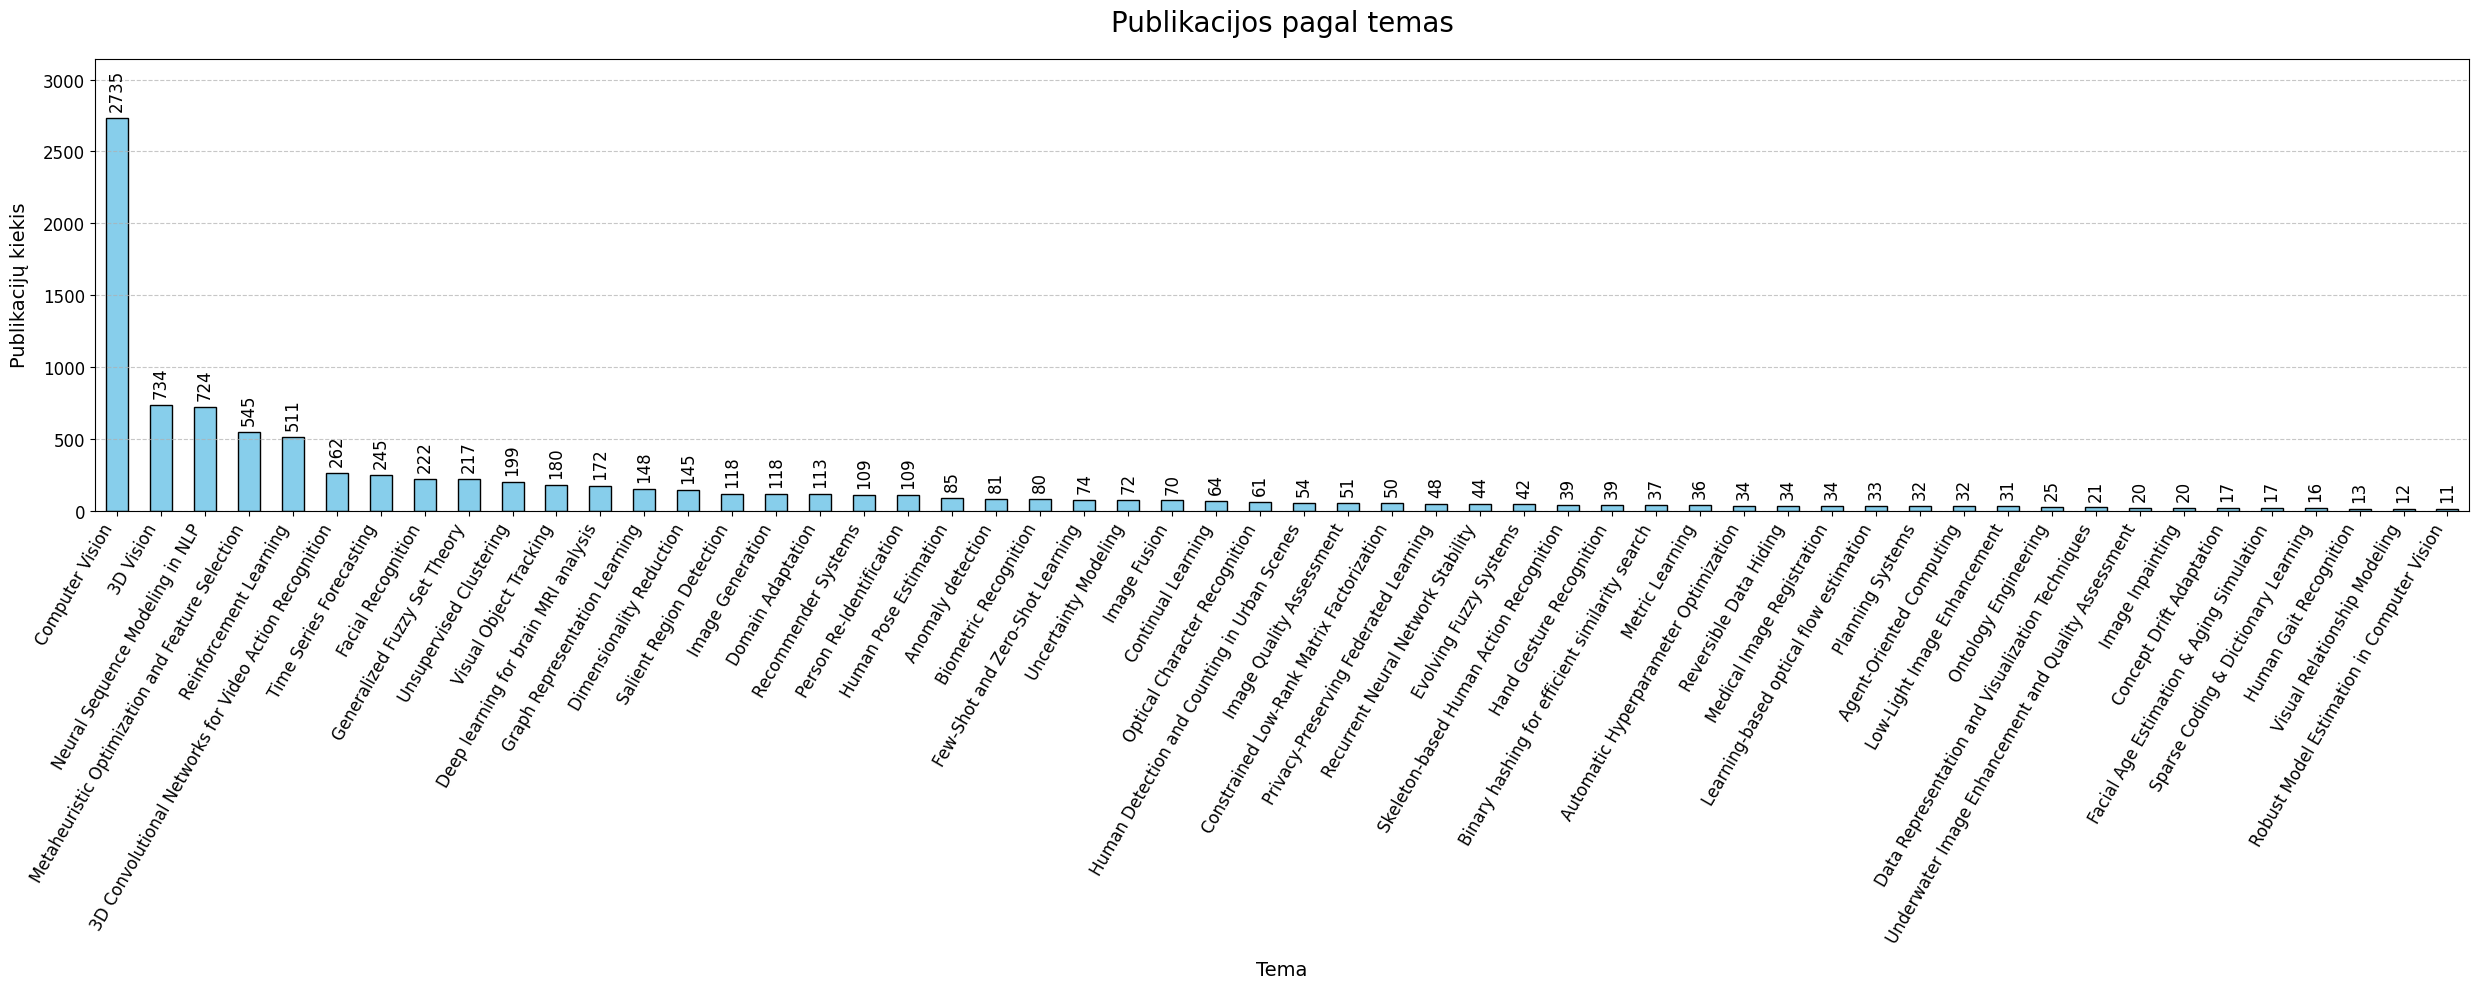

In [17]:
import matplotlib.pyplot as plt

topic_counts = df['Topic'].value_counts()

plt.figure(figsize=(25, 10))

ax = topic_counts.plot(kind='bar', color='skyblue', edgecolor='black')
ax.bar_label(ax.containers[0], fontsize=12, padding=5, rotation=90, fmt='%.0f')

plt.ylim(0, topic_counts.max() * 1.15)
plt.title('Publikacijos pagal temas', fontsize=20, pad=20)
plt.xlabel('Tema', fontsize=14, labelpad=10)
plt.ylabel('Publikacijų kiekis', fontsize=14, labelpad=10)
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

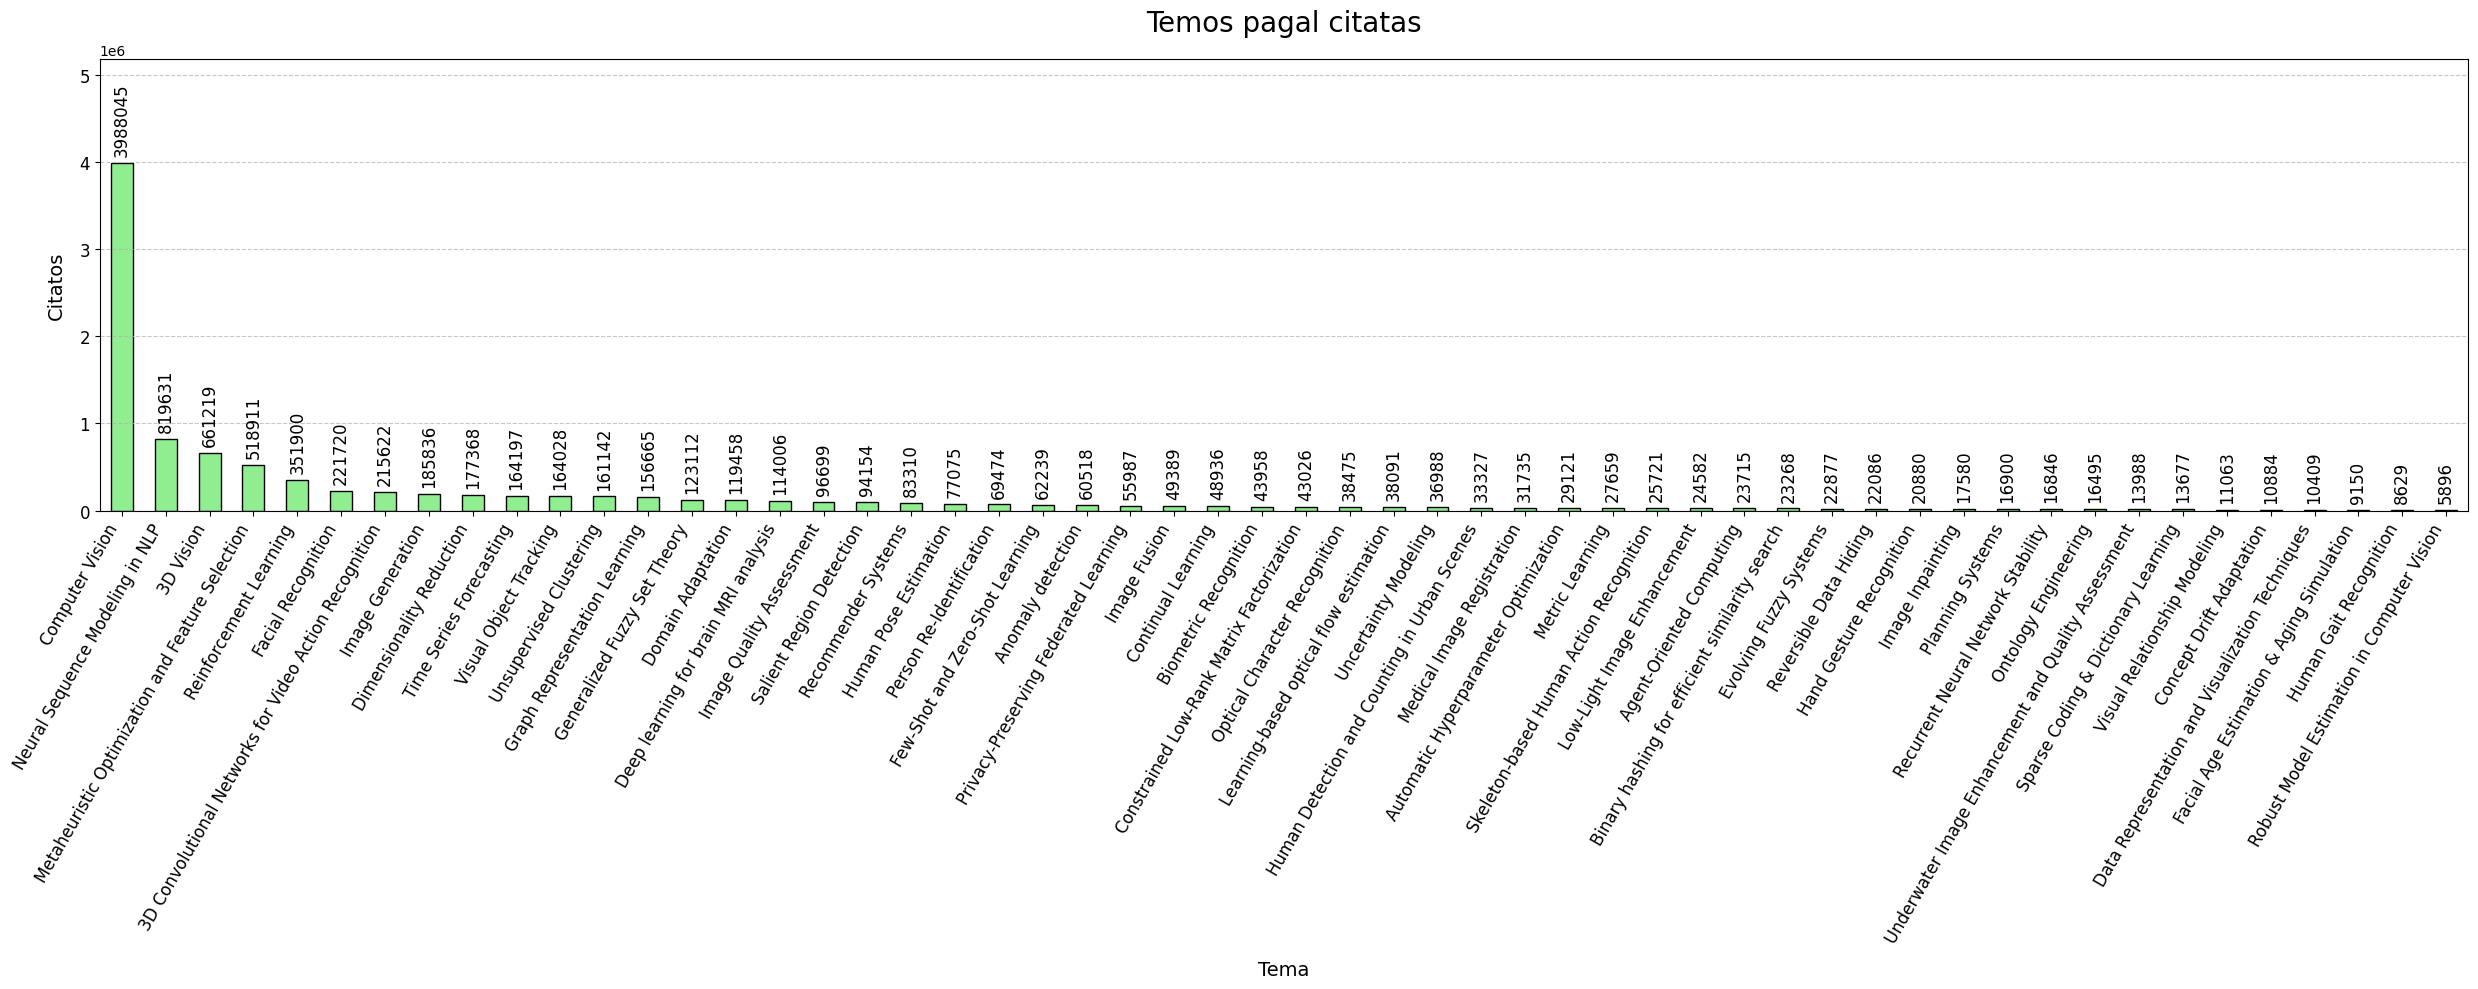

In [18]:
import matplotlib.pyplot as plt

topic_citations = df.groupby('Topic')['Times Cited'].sum().sort_values(ascending=False)

plt.figure(figsize=(25, 10))

ax = topic_citations.plot(kind='bar', color='lightgreen', edgecolor='black')
ax.bar_label(ax.containers[0], fontsize=12, padding=5, rotation=90, fmt='%.0f')

plt.ylim(0, topic_citations.max() * 1.3)
plt.title('Temos pagal citatas', fontsize=20, pad=20)
plt.xlabel('Tema', fontsize=14, labelpad=10)
plt.ylabel('Citatos', fontsize=14, labelpad=10)
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Taigi, 2 įtakingiausios temos yra:

In [19]:
df.groupby('Topic')['Times Cited'].sum().sort_values(ascending=False).head(2).reset_index()

,Topic,Times Cited
0,Computer Vision,3988045
1,Neural Sequence Modeling in NLP,819631


Išsaugome duomenų šaltinį, papildytą įterpiniais, klasteriais ir generuotomis temomis

In [20]:
df.to_csv('./dataset/generated/papers_clustered.csv', index=False, sep=',')

Sukuriame pagalbines funkcijas:
- `get_authors_adjacency_list`
- `get_total_citations_per_author`

In [29]:
from collections import defaultdict

def get_authors_adjacency_list(df, topic=None):
    if topic is not None:
        df_filtered = df[df['Topic'] == topic]
    else:
        df_filtered = df

    sub = (
        df_filtered[['Authors']]
        .dropna(subset=['Authors'])
        .reset_index(drop=True)
    )

    sub['author_list'] = sub['Authors'].str.split(';')

    adjacency = defaultdict(lambda: defaultdict(lambda: {'weight': 0}))

    for idx, row in sub.iterrows():
        authors = [a.strip() for a in row['author_list'] if a.strip()]

        for i, a1 in enumerate(authors):
            for a2 in authors[i+1:]:
                adjacency[a1][a2]['weight'] += 1
                adjacency[a2][a1]['weight'] += 1  # undirected
                
    edges = (
        pd.DataFrame(
            [(a, b, d['weight'])
             for a, nbrs in adjacency.items()
             for b, d in nbrs.items()],
            columns=['Source', 'Target', 'CoAuthored']
        )
        .sort_values('CoAuthored', ascending=False)
        .reset_index(drop=True)
    )

    return edges

def get_total_citations_per_author(df, topic=None):
    if topic is not None:
        df_filtered = df[df['Topic'] == topic]
    else:
        df_filtered = df

    df_authors = df_filtered[['Authors', 'Times Cited']].dropna().copy()

    author_citations = defaultdict(int)

    for _, row in df_authors.iterrows():
        authors = [a.strip() for a in row['Authors'].split(';') if a.strip()]
        citations = row['Times Cited']

        for author in authors:
            author_citations[author] += citations

    result_df = pd.DataFrame(list(author_citations.items()), columns=['Author', 'Total Citations'])
    result_df = result_df.sort_values('Total Citations', ascending=False).reset_index(drop=True)

    return result_df

In [30]:
for index, row in df.groupby('Topic')['Times Cited'].sum().sort_values(ascending=False).head(2).reset_index().iterrows():
    df_topic = get_authors_adjacency_list(df, row['Topic'])
    df_topic.to_csv(f'./dataset/generated/topic_{index + 1}_adjacency.csv', index=False, sep=',')

In [31]:
df_topic = get_authors_adjacency_list(df)
df_topic.to_csv('./dataset/generated/adjacency.csv', index=False, sep=',')
df_topic

,Source,Target,CoAuthored
0,"Li, YM","Tong, SC",23
1,"Tong, SC","Li, YM",23
2,"Long, MS","Wang, JM",20
3,"Wang, JM","Long, MS",20
4,"Van Gool, L","Timofte, R",19
...,...,...,...
252219,"Bischof, H","Choi, S",1
252220,"Bischof, H","Wu, TF",1
252221,"Bischof, H","Pridmore, T",1
252222,"Bischof, H","Hu, WM",1


In [32]:
df_topic = get_total_citations_per_author(df, topic=None)
df_topic.to_csv('./dataset/generated/author_citations.csv', index=False, sep=',')
df_topic

,Author,Total Citations
0,"He, KM",336843
1,"Sun, J",271645
2,"Ren, SQ",223321
3,"Girshick, R",219462
4,"Zhang, XY",194403
...,...,...
17632,"Pap, E",280
17633,"Klement, EP",280
17634,"Tumanyan, N",280
17635,"Leng, JW",279
